# Kaggle challange: Humpback Whale Identification Challenge

Find the id of a whale using an image from the tail of a whale

https://www.kaggle.com/c/whale-categorization-playground/data

In [66]:
#import for tensorflow 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [172]:
TEST_IMAGES = "./data/test/"
TRAIN_IMAGES = "./data/train/"
TRAIN_LABELS = "./data/train.csv"
SAMPLE_SUBMITION = "./data/sample_submission.csv"

### Read csv data of train.csv and sample submission

In [157]:
df_train = pd.read_csv(TRAIN_LABELS)

In [158]:
print("format of training whales is {}".format(df_train.values.shape))
print("number of uniqeu whales is {}".format(len(df_train.Id.unique())))

df_train.head(10)

format of training whales is (9850, 2)
number of uniqeu whales is 4251


,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0031c258.jpg,new_whale
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782


In [257]:
# read sample submittion to obtain test images links
df_test = pd.read_csv(SAMPLE_SUBMITION)
print("number of test-images is {}".format(len(df_test.Image.values)))
df_test.head(2)

number of test-images is 15610


,Image,Id
0,00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
1,0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46


### Read an Image

In [275]:
def make_plot_whales(whales):
    fig, axes = plt.subplots(2, int(len(whales)/2))
    fig.set_size_inches(18, 6)

    for i, _ in enumerate(axes):
        for j, ax in enumerate(axes[i]):
            index = len(axes[0])*i + j
            try:
                image = mpimg.imread(TRAIN_IMAGES + whales[index][0])
            except:
                image = mpimg.imread(TEST_IMAGES + whales[index][0])
            im = ax.imshow(image, cmap = 'gray')
            ax.set_title(whales[index][1])

    plt.show()

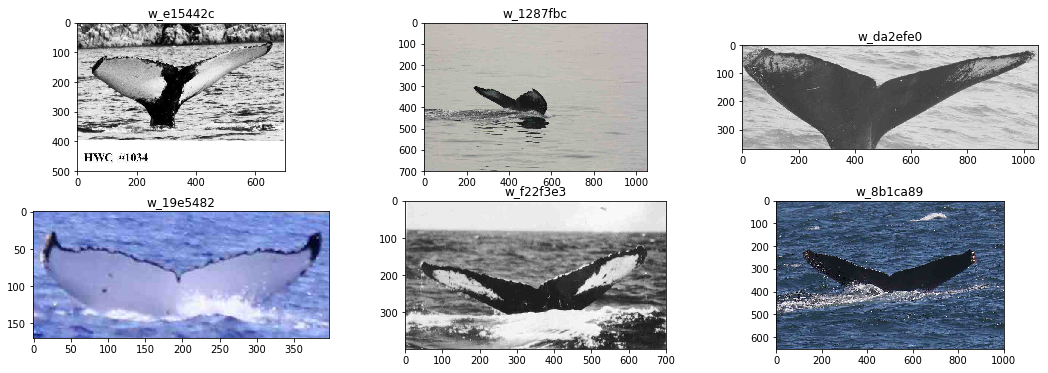

In [276]:
make_plot_whales(list(df_train.values)[:6])

#### Train data 

In [297]:
train_images = []

train_labels_index = []
labels_names = list(df_train.Id.unique())
del labels_names[labels_names.index('new_whale')]
print(len(labels_names))               

i = 0 
for image_path, whale_id in df_train.values:
    if whale_id == 'new_whale':
        continue
    #read image
    image = cv2.imread(TRAIN_IMAGES +image_path, 0)
    
    #crop image to 28 X 28:
    image = cv2.resize(image, (28, 28)) 
   
    train_images.append(image)
   
    # get index for one hot vector 
    j = labels_names.index(whale_id)
    train_labels_index.append(j)

# cast to right type for cnn
train_images = np.asarray(train_images, dtype=np.float32)
train_labels_index = np.asarray(train_labels_index, dtype=np.int32)


4250


In [290]:
print(train_images.shape)
print(train_labels_index.shape)

(9040, 28, 28)
(9040,)


In [295]:
print(type(train_images[0][0][0]))

<class 'numpy.float32'>


#### test data 

In [258]:
test_images = []
for image_path, _ in df_test.values:
    #read image
    image = cv2.imread(TEST_IMAGES + image_path, 0)

    #crop image to 28 X 28:
    image = cv2.resize(image, (28, 28)) 
    test_images.append(image)
    
test_images = np.asarray(test_images, dtype=np.float32)

In [259]:
print(test_images.shape)

(15610, 28, 28)


## Use a CNN and train it using tensorflow

In [298]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
            inputs=input_layer,
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
            inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=4250)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=4250)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(
                    labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [299]:
# Create the Estimator
whale_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./tensorflow_logs/whale_challange_8")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7530324588>, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_is_chief': True, '_model_dir': './tensorflow_logs/whale_challange_8', '_session_config': None, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_service': None, '_task_type': 'worker'}


In [301]:
#train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_images},
    y=train_labels_index,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

whale_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tensorflow_logs/whale_challange_8/model.ckpt-20000
INFO:tensorflow:Saving checkpoints for 20001 into ./tensorflow_logs/whale_challange_8/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000029 0.00000003 ... 0.         0.00000001 0.00000065]
 [0.00000001 0.         0.         ... 0.         0.         0.        ]
 [0.00000047 0.0000264  0.00001021 ... 0.0000366  0.00004361 0.00004794]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00001294 0.00071276 0.00000918 ... 0.00010686 0.00027    0.00009724]
 [0.         0.00000254 0.00000035 ... 0.00000029 0.00000001 0.00000001]]
INFO:tensorflow:step = 20001, loss = 2.089217
INFO:tensorflow:global_step/sec: 128.009
INFO:tensorflow:step = 20101, loss = 1.5872049 (0.781 sec)
INFO:tensorflow:global_step/sec: 140.957
INFO:tensorflow:step = 20201, loss = 1.568166 (0.709 sec)
INFO:tensorflow:global_step/sec: 139.06
IN

INFO:tensorflow:global_step/sec: 122.469
INFO:tensorflow:step = 25101, loss = 0.47686416 (0.815 sec)
INFO:tensorflow:global_step/sec: 130.255
INFO:tensorflow:step = 25201, loss = 0.56863296 (0.767 sec)
INFO:tensorflow:global_step/sec: 126.201
INFO:tensorflow:step = 25301, loss = 0.4134445 (0.793 sec)
INFO:tensorflow:global_step/sec: 136.709
INFO:tensorflow:step = 25401, loss = 0.60336953 (0.732 sec)
INFO:tensorflow:global_step/sec: 132.951
INFO:tensorflow:step = 25501, loss = 0.37266532 (0.751 sec)
INFO:tensorflow:global_step/sec: 133.431
INFO:tensorflow:step = 25601, loss = 0.42838678 (0.749 sec)
INFO:tensorflow:global_step/sec: 132.836
INFO:tensorflow:step = 25701, loss = 0.4242334 (0.753 sec)
INFO:tensorflow:global_step/sec: 132.603
INFO:tensorflow:step = 25801, loss = 0.50289434 (0.754 sec)
INFO:tensorflow:global_step/sec: 134.556
INFO:tensorflow:step = 25901, loss = 0.34220618 (0.744 sec)
INFO:tensorflow:global_step/sec: 134.574
INFO:tensorflow:probabilities = [[0.00000005 0.00006

INFO:tensorflow:step = 31001, loss = 0.09643303 (0.724 sec)
INFO:tensorflow:global_step/sec: 123.909
INFO:tensorflow:step = 31101, loss = 0.22404373 (0.807 sec)
INFO:tensorflow:global_step/sec: 129.928
INFO:tensorflow:step = 31201, loss = 0.11619575 (0.768 sec)
INFO:tensorflow:global_step/sec: 130.747
INFO:tensorflow:step = 31301, loss = 0.1604965 (0.765 sec)
INFO:tensorflow:global_step/sec: 124.836
INFO:tensorflow:step = 31401, loss = 0.13046955 (0.801 sec)
INFO:tensorflow:global_step/sec: 134.525
INFO:tensorflow:step = 31501, loss = 0.2709947 (0.744 sec)
INFO:tensorflow:global_step/sec: 126.431
INFO:tensorflow:step = 31601, loss = 0.15477194 (0.791 sec)
INFO:tensorflow:global_step/sec: 130.345
INFO:tensorflow:step = 31701, loss = 0.21394634 (0.767 sec)
INFO:tensorflow:global_step/sec: 128.356
INFO:tensorflow:step = 31801, loss = 0.1660825 (0.779 sec)
INFO:tensorflow:global_step/sec: 131.2
INFO:tensorflow:step = 31901, loss = 0.11666448 (0.763 sec)
INFO:tensorflow:global_step/sec: 130

INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00000002 0.00000001 ... 0.         0.         0.        ]
 [0.         0.00032927 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (7.717 sec)
INFO:tensorflow:step = 37001, loss = 0.12338426 (0.792 sec)
INFO:tensorflow:global_step/sec: 133.877
INFO:tensorflow:step = 37101, loss = 0.11480422 (0.745 sec)
INFO:tensorflow:global_step/sec: 131.11
INFO:tensorflow:step = 37201, loss = 0.14269099 (0.763 sec)
INFO:tensorflow:global_step/sec: 134.038
INFO:tensorflow:step = 37301, loss = 0.023661256 (0.746 sec)
INFO:tensorflow:global_step/sec: 132.706
INFO:tensorflow:step = 37401, loss = 0.03605286 (0.755 sec)
INFO:tensorflow:global_step/sec: 135.173
INFO:te

<img src="./images/cnn_second_try.png">
<img src="./images/cnn.png" style="height:400px">

###### LOGS 
1. first cnn with all labels and just in a two layerd cnn
2. same CNN with no new whale labels, chaned dense layer 

# Predict test labels

In [302]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": test_images},
    num_epochs = 1,
    shuffle=False)
prediction = whale_classifier.predict(input_fn = predict_input_fn)

In [303]:
prediction_list = list(prediction)

INFO:tensorflow:Restoring parameters from ./tensorflow_logs/whale_challange_8/model.ckpt-40000


In [304]:
prediction_list = np.array(prediction_list)

In [305]:
prediction_list[1]

{'classes': 1883,
 'probabilities': array([2.3375912e-11, 1.4875899e-08, 7.9736530e-12, ..., 4.5759680e-08,
        1.4599808e-08, 5.5307257e-08], dtype=float32)}

## Plot whales

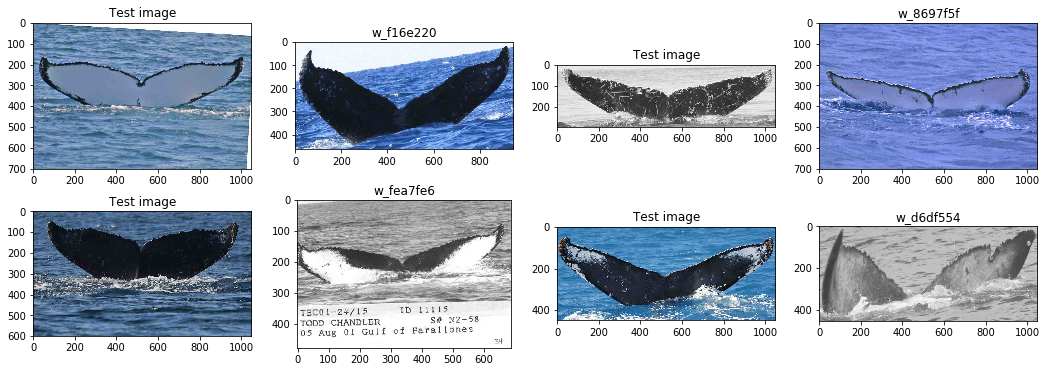

In [306]:
plot_images = []
for idx, prediction in enumerate(prediction_list[16:20]):
    plot_images.append([df_test.Image.values[idx], "Test image"])
    plot_images.append([df_train.Image.unique()[prediction['classes']], df_train.loc[df_train.Image == df_train.Image.unique()[prediction['classes']]].Id.values[0] ])
    
#     plot_images.append([test_images[idx], "Train image"])

make_plot_whales(plot_images)

# Write to csv for submission kaggle

In [238]:
 df_train.loc[df_train.Image == df_train.Image.unique()[prediction['classes']]]

,Image,Id
2255,3a76961c.jpg,w_4c25641


In [239]:
df_train.Image.unique()[prediction['classes']]

'3a76961c.jpg'